In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.optimizers import adam
import keras


Using TensorFlow backend.
/Users/dagdasy/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/dagdasy/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/dagdasy/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/dagdasy/anaconda3/lib/python3.7/site-packag

In [2]:
# loading dataframe
df = pd.read_csv('../train_clean.csv')

In [3]:
# getting a glance at the dataframe
df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,lemma1
0,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,0,0,0,0,0,0,d aww match background colour i m seemingly st...
2,0,0,0,0,0,0,hey man i m really trying edit war guy constan...
3,0,0,0,0,0,0,make real suggestion improvement wondered sect...
4,0,0,0,0,0,0,you sir hero chance remember page that s on


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   toxic          159571 non-null  int64 
 1   severe_toxic   159571 non-null  int64 
 2   obscene        159571 non-null  int64 
 3   threat         159571 non-null  int64 
 4   insult         159571 non-null  int64 
 5   identity_hate  159571 non-null  int64 
 6   lemma1         158049 non-null  object
dtypes: int64(6), object(1)
memory usage: 8.5+ MB


In [5]:
df.dropna(inplace=True)

In [6]:
# Assigning X and y 
X = df.lemma1
y= df.drop(['lemma1'], axis=1)

# splitting train and test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# vectorizing the comments
tf_idf = TfidfVectorizer(max_features=10000, analyzer='word', stop_words='english')
X_train = tf_idf.fit_transform(X_train)
X_test = tf_idf.transform(X_test)
X_train = pd.DataFrame(X_train.toarray())
X_test = pd.DataFrame(X_test.toarray())
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Model

In this notebook, I used neural networks to predict the toxic comments. I have a multilabel, imbalanced dataset. To overcome the imbalance problem and overfitting I have tested several things:

1. Use class_weights during fitting the model.
2. Use early stop to prevent overfitting.
3. Combine method 1 and 2

These three approaches did not yield a very good model. To solve the imbalance problem, I used random oversampling. When I applied random oversampling to multilabels, it did not work well since labels are not exclusive. Even though the labels were not balanced they were not as bad as before so I used that data to train the model. The model worked well on training and test data but model performance was very low on the original data that does not have oversampling (data not included).

Later on I tried two step prediction:
Step 1: Assign a new label whether the comment is toxic or not. Oversample the minority class. Train the model.
Step 2: Filter out data that has toxic comments. Train model on this data.

The first step of this approach worked really well. So the model can predict toxic comments very effectively.
The second step which involves prediction among toxic comments had similar performance to the original approach I have used at the beginning of the notebook.

In [7]:
# Assigning optimizer and learning rate
optimizer=adam(learning_rate=1e-4)

# Assigning metrics for evaluation
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall")]

# Assigning class weights
class_weights={0: y.sum(axis=0)[0]/y.shape[0], 
               1: y.sum(axis=0)[1]/y.shape[0], 
               2: y.sum(axis=0)[2]/y.shape[0] , 
               3: y.sum(axis=0)[3]/y.shape[0], 
               4: y.sum(axis=0)[4]/y.shape[0], 
               5: y.sum(axis=0)[5]/y.shape[0]}

# Assigning early stop
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [8]:
# Creating the first model that does not have early stop or class weights
model_1 = Sequential()
model_1.add(Dense(50, input_dim=X_train.shape[1], kernel_initializer='he_uniform', activation='relu'))
model_1.add(Dropout(0.1))
model_1.add(Dense(50, kernel_initializer='he_uniform', activation='relu'))
model_1.add(Dense(y_train.shape[1], activation='sigmoid'))
model_1.compile(loss='binary_crossentropy', optimizer=optimizer ,metrics= metrics)
history_1 = model_1.fit(X_train, y_train, epochs = 30, validation_data=(X_val, y_val),verbose=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



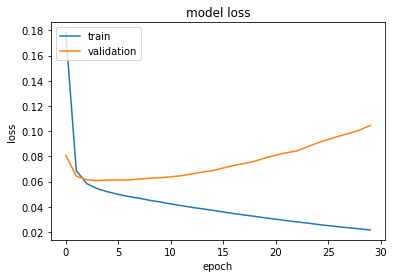

In [9]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.show()

In [10]:
train_pred = model_1.predict(X_train)
test_pred = model_1.predict(X_test)
train_pred = pd.DataFrame(train_pred.round())
test_pred = pd.DataFrame(test_pred.round())

In [11]:
print(classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      9634
           1       0.73      0.61      0.67       991
           2       0.95      0.93      0.94      5308
           3       0.86      0.38      0.53       321
           4       0.90      0.91      0.90      4954
           5       0.90      0.75      0.82       864

   micro avg       0.93      0.89      0.91     22072
   macro avg       0.88      0.75      0.80     22072
weighted avg       0.93      0.89      0.91     22072
 samples avg       0.09      0.09      0.09     22072



/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       0.76      0.66      0.71      3102
           1       0.45      0.31      0.37       328
           2       0.82      0.70      0.75      1780
           3       0.54      0.15      0.23        88
           4       0.69      0.62      0.66      1648
           5       0.63      0.34      0.44       304

   micro avg       0.74      0.63      0.68      7250
   macro avg       0.65      0.46      0.53      7250
weighted avg       0.74      0.63      0.67      7250
 samples avg       0.06      0.06      0.06      7250



/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
# Creating the second model that has early stop but not class weights
model_2 = Sequential()
model_2.add(Dense(50, input_dim=X_train.shape[1], kernel_initializer='he_uniform', activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(50, kernel_initializer='he_uniform', activation='relu'))
model_2.add(Dense(y_train.shape[1], activation='sigmoid'))
model_2.compile(loss='binary_crossentropy', optimizer=optimizer ,metrics= metrics)
history_2 = model_2.fit(X_train, y_train, epochs = 30, validation_data=(X_val, y_val),verbose=0,callbacks=[es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 00005: early stopping


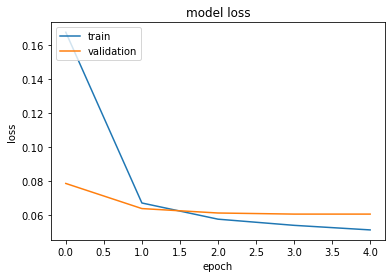

In [9]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.show()

In [10]:
train_pred = model_2.predict(X_train)
test_pred = model_2.predict(X_test)
train_pred = pd.DataFrame(train_pred.round())
test_pred = pd.DataFrame(test_pred.round())

In [11]:
print(classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80      9634
           1       0.73      0.02      0.04       991
           2       0.83      0.75      0.79      5308
           3       0.00      0.00      0.00       321
           4       0.76      0.66      0.70      4954
           5       0.00      0.00      0.00       864

   micro avg       0.84      0.65      0.73     22072
   macro avg       0.53      0.36      0.39     22072
weighted avg       0.79      0.65      0.70     22072
 samples avg       0.06      0.06      0.06     22072



/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       0.85      0.66      0.74      3102
           1       0.75      0.03      0.05       328
           2       0.81      0.71      0.76      1780
           3       0.00      0.00      0.00        88
           4       0.74      0.63      0.68      1648
           5       0.00      0.00      0.00       304

   micro avg       0.81      0.60      0.69      7250
   macro avg       0.52      0.34      0.37      7250
weighted avg       0.76      0.60      0.66      7250
 samples avg       0.06      0.06      0.05      7250



/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
# Creating the third model that uses class weights
model_3 = Sequential()
model_3.add(Dense(50, input_dim=X_train.shape[1], kernel_initializer='he_uniform', activation='relu'))
model_3.add(Dropout(0.1))
model_3.add(Dense(50, kernel_initializer='he_uniform', activation='relu'))
model_3.add(Dense(y_train.shape[1], activation='sigmoid'))
model_3.compile(loss='binary_crossentropy', optimizer=optimizer ,metrics= metrics)
history_3 = model_3.fit(X_train, y_train, epochs = 30, validation_data=(X_val, y_val),verbose=0,class_weight=class_weights)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



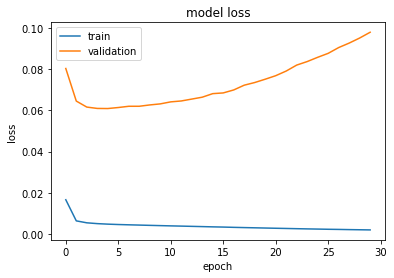

In [9]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.show()

In [10]:
train_pred = model_3.predict(X_train)
test_pred = model_3.predict(X_test)
train_pred = pd.DataFrame(train_pred.round())
test_pred = pd.DataFrame(test_pred.round())

In [11]:
print(classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      9634
           1       0.70      0.52      0.60       991
           2       0.96      0.92      0.94      5308
           3       0.87      0.47      0.61       321
           4       0.91      0.90      0.90      4954
           5       0.88      0.73      0.80       864

   micro avg       0.93      0.89      0.91     22072
   macro avg       0.88      0.75      0.80     22072
weighted avg       0.93      0.89      0.91     22072
 samples avg       0.09      0.09      0.09     22072



/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       0.76      0.67      0.71      3102
           1       0.48      0.29      0.36       328
           2       0.82      0.70      0.75      1780
           3       0.64      0.18      0.28        88
           4       0.69      0.63      0.66      1648
           5       0.65      0.37      0.47       304

   micro avg       0.74      0.63      0.68      7250
   macro avg       0.67      0.47      0.54      7250
weighted avg       0.74      0.63      0.68      7250
 samples avg       0.06      0.06      0.06      7250



/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
# Creating the third model that uses class weights
model_4 = Sequential()
model_4.add(Dense(50, input_dim=X_train.shape[1], kernel_initializer='he_uniform', activation='relu'))
model_4.add(Dropout(0.1))
model_4.add(Dense(50, kernel_initializer='he_uniform', activation='relu'))
model_4.add(Dense(y_train.shape[1], activation='sigmoid'))
model_4.compile(loss='binary_crossentropy', optimizer=optimizer ,metrics= metrics)
history_4 = model_4.fit(X_train, y_train, epochs = 30, validation_data=(X_val, y_val),verbose=0,class_weight=class_weights,callbacks=[es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 00006: early stopping


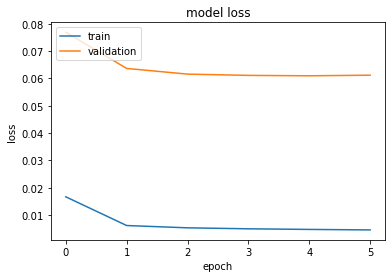

In [9]:
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.show()

In [10]:
train_pred = model_4.predict(X_train)
test_pred = model_4.predict(X_test)
train_pred = pd.DataFrame(train_pred.round())
test_pred = pd.DataFrame(test_pred.round())

In [11]:
print(classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81      9634
           1       0.00      0.00      0.00       991
           2       0.84      0.76      0.79      5308
           3       0.00      0.00      0.00       321
           4       0.75      0.68      0.71      4954
           5       0.00      0.00      0.00       864

   micro avg       0.84      0.66      0.74     22072
   macro avg       0.41      0.36      0.39     22072
weighted avg       0.76      0.66      0.70     22072
 samples avg       0.07      0.06      0.06     22072



/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       0.84      0.66      0.74      3102
           1       1.00      0.01      0.01       328
           2       0.81      0.72      0.76      1780
           3       0.00      0.00      0.00        88
           4       0.73      0.65      0.69      1648
           5       0.00      0.00      0.00       304

   micro avg       0.80      0.61      0.69      7250
   macro avg       0.56      0.34      0.37      7250
weighted avg       0.77      0.61      0.66      7250
 samples avg       0.06      0.06      0.05      7250



/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
df = pd.read_csv('../train_clean.csv')
df.dropna(inplace=True)

In [10]:
df.loc[(df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=1) != 0),'clean'] = 0
df.loc[(df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=1) == 0),'clean']= 1

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158049 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   toxic          158049 non-null  int64  
 1   severe_toxic   158049 non-null  int64  
 2   obscene        158049 non-null  int64  
 3   threat         158049 non-null  int64  
 4   insult         158049 non-null  int64  
 5   identity_hate  158049 non-null  int64  
 6   lemma1         158049 non-null  object 
 7   clean          158049 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 10.9+ MB


In [12]:
#class_0 = df.toxic!=0
#class_1 = df.severe_toxic!=0
#class_2 = df.obscene!=0
#class_3 = df.threat!=0
#class_4 = df.insult!=0
#class_5 = df.identity_hate!=0
class_1 = df.clean!=0

In [13]:
df_class_1 = df[class_1]
df_class_1_negative = df[~class_1]
ids = np.arange(len(df_class_1_negative))
choices = np.random.choice(ids, len(df_class_1))
df_class_1_resample = df_class_1_negative.iloc[choices]

In [14]:
resampled = pd.concat([df_class_1,df_class_1_resample], axis=0)

In [17]:
resampled.columns

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',
       'lemma1', 'clean'],
      dtype='object')

In [18]:
# Assigning X and y 
X = resampled.lemma1
y= resampled.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',
       'lemma1'], axis=1)

# splitting train and test data

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# vectorizing the comments
tf_idf = TfidfVectorizer(max_features=10000, analyzer='word', stop_words='english')
X_train = tf_idf.fit_transform(X_train)
X_test = tf_idf.transform(X_test)
X_train = pd.DataFrame(X_train.toarray())
X_test = pd.DataFrame(X_test.toarray())
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [19]:
# Assigning optimizer and learning rate
optimizer=adam(learning_rate=1e-4)

# Assigning metrics for evaluation
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall")]

# Assigning early stop
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [22]:
# Creating the first model that does not have early stop or class weights
model_5 = Sequential()
model_5.add(Dense(50, input_dim=X_train.shape[1], kernel_initializer='he_uniform', activation='relu'))
model_5.add(Dropout(0.1))
model_5.add(Dense(50, kernel_initializer='he_uniform', activation='relu'))
model_5.add(Dense(y_train.shape[1], activation='sigmoid'))
model_5.compile(loss='binary_crossentropy', optimizer=optimizer ,metrics= metrics)
history_5 = model_5.fit(X_train, y_train, epochs = 30, validation_data=(X_val, y_val),verbose=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



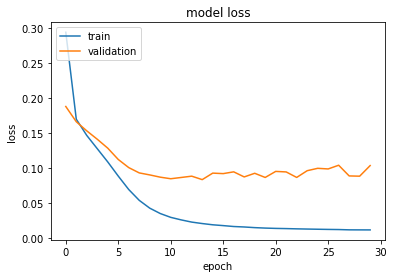

In [23]:
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.show()

In [24]:
train_pred = model_5.predict(X_train)
test_pred = model_5.predict(X_test)
train_pred = pd.DataFrame(train_pred.round())
test_pred = pd.DataFrame(test_pred.round())

In [25]:
print(classification_report(y_train,train_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     90753
         1.0       0.99      1.00      1.00     90984

    accuracy                           1.00    181737
   macro avg       1.00      1.00      1.00    181737
weighted avg       1.00      1.00      1.00    181737



In [26]:
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     28536
         1.0       0.99      0.97      0.98     28258

    accuracy                           0.98     56794
   macro avg       0.98      0.98      0.98     56794
weighted avg       0.98      0.98      0.98     56794



In [2]:
df = pd.read_csv('../train_clean.csv')
df.dropna(inplace=True)

In [3]:
df.loc[(df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=1) != 0),'clean'] = 0
df.loc[(df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=1) == 0),'clean']= 1

In [4]:
df = df[df.clean==0]

In [5]:
# Assigning X and y 
X = df.lemma1
y= df.drop(['clean','lemma1'], axis=1)

# splitting train and test data

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# vectorizing the comments
tf_idf = TfidfVectorizer(max_features=10000, analyzer='word', stop_words='english')
X_train = tf_idf.fit_transform(X_train)
X_test = tf_idf.transform(X_test)
X_train = pd.DataFrame(X_train.toarray())
X_test = pd.DataFrame(X_test.toarray())
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [6]:
# Assigning optimizer and learning rate
optimizer=adam(learning_rate=1e-4)

# Assigning metrics for evaluation
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall")]

# Assigning early stop
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [7]:
# Creating the first model that does not have early stop or class weights
model_6 = Sequential()
model_6.add(Dense(50, input_dim=X_train.shape[1], kernel_initializer='he_uniform', activation='relu'))
model_6.add(Dropout(0.1))
model_6.add(Dense(50, kernel_initializer='he_uniform', activation='relu'))
model_6.add(Dense(y_train.shape[1], activation='sigmoid'))
model_6.compile(loss='binary_crossentropy', optimizer=optimizer ,metrics= metrics)
history_6 = model_6.fit(X_train, y_train, epochs = 30, validation_data=(X_val, y_val),verbose=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



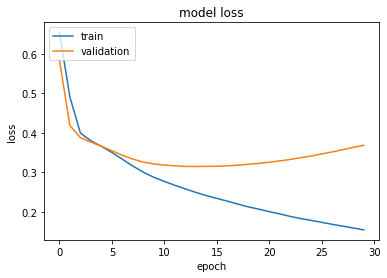

In [8]:
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.show()

In [9]:
train_pred = model_6.predict(X_train)
test_pred = model_6.predict(X_test)
train_pred = pd.DataFrame(train_pred.round())
test_pred = pd.DataFrame(test_pred.round())

In [10]:
print(classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      9710
           1       0.72      0.54      0.62      1037
           2       0.95      0.95      0.95      5373
           3       0.89      0.03      0.05       310
           4       0.90      0.92      0.91      4969
           5       0.89      0.69      0.78       894

   micro avg       0.93      0.92      0.92     22293
   macro avg       0.88      0.69      0.71     22293
weighted avg       0.92      0.92      0.92     22293
 samples avg       0.93      0.94      0.92     22293



/Users/dagdasy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3021
           1       0.44      0.33      0.38       316
           2       0.77      0.74      0.76      1712
           3       1.00      0.01      0.02        95
           4       0.69      0.67      0.68      1613
           5       0.61      0.32      0.42       287

   micro avg       0.82      0.79      0.80      7044
   macro avg       0.74      0.51      0.54      7044
weighted avg       0.81      0.79      0.79      7044
 samples avg       0.84      0.82      0.79      7044

